In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne.decoding import GeneralizingEstimator, LinearModel, SlidingEstimator
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm_notebook
from eelbrain import *

In [2]:
#load the dataset
print('Prepare EEG dataset. May take some time')
eeg = []
for subj in tqdm_notebook(range(21), desc='loading data'):
    tmp = []
    dataSub = loadmat(f"datasetCND_musicImagery/musicImagery/dataCND/dataSub{subj+1}.mat")
    for n in range(88):
        tmp.append(dataSub['eeg']['data'][0,0][0,n].T)
    eeg.append(np.asarray(tmp))
eeg = np.asarray(eeg)
met = loadmat('datasetCND_musicImagery/musicImagery/dataCND/metronome.mat')
met = met['met']
idx_met = np.where(met[:,0] != 0)[0]
for imet in idx_met:
    eeg[:,:,:,imet:imet+34] = 0
a_ma = np.ma.masked_equal(eeg,0)
eeg = np.array([i.compressed() for i in a_ma]).reshape(21,88,64,1803 - 34*len(idx_met))


scores = np.zeros((eeg.shape[0],eeg.shape[3],eeg.shape[3]))

chorals = np.asarray([i//11 for i in range(44)])
classes = set(chorals)
confusion_pred = np.zeros((eeg.shape[0], len(set(chorals)), len(classes)))
confusion_img = np.zeros((eeg.shape[0], len(set(chorals)), len(classes)))
confusion_lis = np.zeros((eeg.shape[0], len(set(chorals)), len(classes)))

[a, _] = random_split(range(44), [44, 0], generator=torch.Generator().manual_seed(42))
idx = a.indices

print('##### Done! ######')

Prepare EEG dataset. May take some time


loading data:   0%|          | 0/21 [00:00<?, ?it/s]

##### Done! ######


In [3]:
acc_pred = np.zeros((eeg.shape[0]))
acc_img = np.zeros((eeg.shape[0],))
acc_lis = np.zeros((eeg.shape[0],))
for sbj in tqdm_notebook(range(21), desc='Classify EEG signals for all Subjects'):
    data_pred =  load.unpickle(f'../Pred_img/sbj{sbj}_Pred.pkl')
    data_img = eeg[sbj,-44:,:,:1394]
    data_lis = eeg[sbj,:44,:,:1394]


    clf = make_pipeline(StandardScaler(),  # z-score normalization
                    LinearModel(LogisticRegression(penalty = 'l2', C=1, 
                                solver = 'liblinear')))
    decoder = SlidingEstimator(clf,scoring='accuracy',n_jobs=-1,verbose=False)
    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    # Compute confusion matrix for each cross-validation fold
    X = data_pred
    y = chorals[idx]
    y_pred = np.zeros((len(y), data_pred.shape[2],len(classes)))
    for train, test_t in cv.split(X, y):
        # Fit
        decoder.fit(X[train], y[train])
        # Probabilistic prediction
        y_pred[test_t] = decoder.predict_proba(X[test_t])
    tmp = y_pred.mean(axis = 1)
    acc_pred[sbj] = sum(tmp.argmax(1) == y)/44
    for ii, train_class in enumerate(classes):
        for jj in range(ii, len(classes)):
            confusion_pred[sbj, ii, jj] = roc_auc_score(y == train_class,tmp[:, jj])
            confusion_pred[sbj, jj, ii] = confusion_pred[sbj, ii, jj]


    clf = make_pipeline(StandardScaler(),  # z-score normalization
                    LinearModel(LogisticRegression(penalty = 'l2', C=1, 
                                solver = 'liblinear')))
    decoder = SlidingEstimator(clf,scoring='accuracy',n_jobs=-1,verbose=False)  
    X = data_img
    y = chorals
    y_img = np.zeros((len(y), data_pred.shape[2],len(classes)))
    for train, test_t in cv.split(X, y):
        # Fit
        decoder.fit(X[train], y[train])
        # Probabilistic prediction
        y_img[test_t] = decoder.predict_proba(X[test_t])
    tmp = y_img.mean(axis = 1)
    acc_img[sbj] = sum(tmp.argmax(1) == y)/44
    for ii, train_class in enumerate(classes):
        for jj in range(ii, len(classes)):
            confusion_img[sbj, ii, jj] = roc_auc_score(y == train_class,tmp[:, jj])
            confusion_img[sbj, jj, ii] = confusion_img[sbj, ii, jj]


    clf = make_pipeline(StandardScaler(),  # z-score normalization
                    LinearModel(LogisticRegression(penalty = 'l2', C=1, 
                                solver = 'liblinear')))
    decoder = SlidingEstimator(clf,scoring='accuracy',n_jobs=-1,verbose=False)  
    X = data_lis
    y = chorals
    y_lis = np.zeros((len(y), data_pred.shape[2],len(classes)))
    for train, test_t in cv.split(X, y):
        # Fit
        decoder.fit(X[train], y[train])
        # Probabilistic prediction 
        y_lis[test_t] = decoder.predict_proba(X[test_t])
    tmp = y_lis.mean(axis = 1)
    acc_lis[sbj] = sum(tmp.argmax(1) == y)/44
    for ii, train_class in enumerate(classes):
        for jj in range(ii, len(classes)):
            confusion_lis[sbj, ii, jj] = roc_auc_score(y == train_class,tmp[:, jj])
            confusion_lis[sbj, jj, ii] = confusion_lis[sbj, ii, jj]

Classify EEG signals for all Subjects:   0%|          | 0/21 [00:00<?, ?it/s]

In [4]:
## Grand Average, Confusion Matrix
CM_pred = confusion_pred.mean(0)
CM_img = confusion_img.mean(0)
CM_lis = confusion_lis.mean(0)

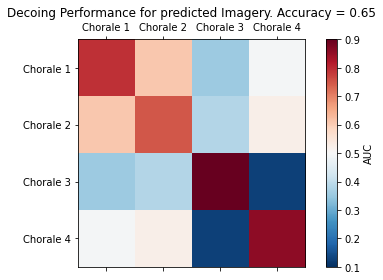

In [5]:
labels = [f'Chorale {i}' for i in range(1,5)]

fig, ax = plt.subplots(1)
im = ax.matshow(CM_pred, cmap='RdBu_r', clim=[0.1, .9])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title(f'Decoing Performance for predicted Imagery. Accuracy = {round(acc_pred.mean(),2)}')
clt = plt.colorbar(im)
clt.set_label('AUC')
plt.tight_layout()
# plt.savefig('../Figures/CM_trainLis_testImg.pdf', bbox_inches='tight')
plt.show()

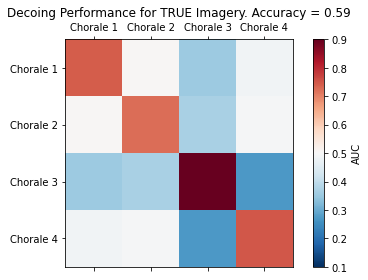

In [6]:
fig, ax = plt.subplots(1)
im = ax.matshow(CM_img, cmap='RdBu_r', clim=[0.1, .9])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title(f'Decoing Performance for TRUE Imagery. Accuracy = {round(acc_img.mean(),2)}')
clt = plt.colorbar(im)
clt.set_label('AUC')
plt.tight_layout()
# plt.savefig('../Figures/CM_trainPred_testImg.pdf', bbox_inches='tight')
plt.show()

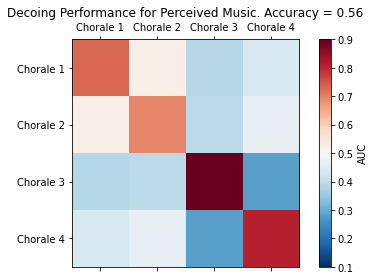

In [8]:
fig, ax = plt.subplots(1)
im = ax.matshow(CM_lis, cmap='RdBu_r', clim=[0.1, .9])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title(f'Decoing Performance for Perceived Music. Accuracy = {round(acc_lis.mean(),2)}')
clt = plt.colorbar(im)
clt.set_label('AUC')
plt.tight_layout()
# plt.savefig('../Figures/CM_trainPred_testImg.pdf', bbox_inches='tight')
plt.show()